# Regularization of linear models using L1 regularization

Author: Juvid Aryaman

We're interested in performing the regression problem

$$\mathbf{y}=\mathbf{Xw}$$

where $\mathbf{X}$ is a matrix with $N$ rows (amount of data) and $D$ columns (number of dimensions). We're often interested in the case where $D > N$, so we do not want to use all of the available dimensions in our weight vector $\mathbf{w}$. In order to do this, we penalize large weights. We can think of this as optimizing the following objective function

$$f(\mathbf{w})=||\mathbf{y}-\mathbf{Xw}||_2^2 + \lambda ||\mathbf{w}||_n$$

where $n$ is the order of the norm of the vector. It turns out that when $n=1$, the solution $\mathbf{w}$ is sparse. This is called a regularizer for the regression problem, and is often denoted as $l_n$. The sparsity property of $l_1$ regularizers can be appreciated using the simple example of $\mathbf{w}_1=(1/\sqrt{2},1/\sqrt{2})$ versus $\mathbf{w}_2=(1,0)$. Under an $l_2$ norm, both of these vectors have the same magnitude (1), but under an $l_1$ norm, $w_2$ is shorter than $w_1$.

Based on Ch13 of Murphy, Machine Learning: A Probabilistic Perspective

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import utls
import pandas as pd
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split

In [2]:
%matplotlib inline
utls.reset_plots()

In [3]:
d = pd.read_csv('../Data/prostate.csv', delimiter = '\t',index_col=0).reset_index(drop=True)
d.head()

,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa,train
0,-0.579818,2.769459,50,-1.386294,0,-1.386294,6,0,-0.430783,T
1,-0.994252,3.319626,58,-1.386294,0,-1.386294,6,0,-0.162519,T
2,-0.510826,2.691243,74,-1.386294,0,-1.386294,7,20,-0.162519,T
3,-1.203973,3.282789,58,-1.386294,0,-1.386294,6,0,-0.162519,T
4,0.751416,3.432373,62,-1.386294,0,-1.386294,6,0,0.371564,T


In [4]:
d.train.unique()

array(['T', 'F'], dtype=object)

These data already have a test/train split, so we'll just use those 

In [5]:
features = list(d.columns)[:-2]

In [6]:
train = d[d['train']=='T']
test = d[d['train']=='F']

xtrain = utls.standardize(train[features]).as_matrix()
ytrain = utls.standardize(train['lpsa']).as_matrix()

xtest = utls.standardize(test[features]).as_matrix()
ytest = utls.standardize(test['lpsa']).as_matrix()

len(xtrain), len(xtest)

(67, 30)

## Use cross-validation and the 1 standard error rule to pick regularizer for Lasso

This is a frequentist method for model selection in the case where we are attempting to predict observable quantities. If we have a loss function $L(y_i,f_\lambda^k(\mathbf{x}_i))$ where $\lambda$ is some hyper-parameter of our model (in this case, the regularizer value). We have $k=1,\dots,K$ 'folds', where we randomly partition the data into $K$ equally-sized sets. $f_\lambda^k(\mathbf{x}_i)$ is the prediction function trained on data excluding the $k$th fold, given the hyperparameter value $\lambda$. In this case, the loss function is simply the residual sum of squared errors between the prediction and the true value of the response $y_i$. 

To perform model selection, a heuristic often used is to compute the standard error in the loss across the $K$ folds

$$SE(\lambda_i) = \sqrt{\frac{\mathbb{V}(L_1(\lambda_i),\dots,L_K(\lambda_i))}{K}}$$

where $L_j(\lambda_i)$ is the loss for the $j$th fold for $\lambda_i$. Then choose the model with the least number of parameters which is no more than 1 standard error away from the best model.

In [7]:
from sklearn.model_selection import KFold

In [8]:
regularizer_max = np.linalg.norm(np.dot(xtrain.T,ytrain),ord=np.inf) # find the maximum value of the regularizer (Eq 13.57 Murphy)
regularizer_max

48.38823967871569

In [9]:
alpha_space = np.logspace(np.log10(0.001),np.log10(regularizer_max))

In [10]:
n_folds = 5
kf = KFold(n_splits=n_folds, shuffle=True, random_state=1) # split the data into k consecutive folds

In [11]:
loss_alpha_arr = np.zeros((len(alpha_space),n_folds))
weight_counts = []
for i, alpha_val in enumerate(alpha_space):
    j=0
    for train_index, test_index in kf.split(xtrain):
        xtrain_k, x_test_k = xtrain[train_index], xtrain[test_index]
        ytrain_k, y_test_k = ytrain[train_index], ytrain[test_index]
        clf = Lasso(alpha=alpha_val)
        clf.fit(xtrain,ytrain)
        loss_ik = (clf.predict(x_test_k) - y_test_k)**2
        loss_alpha_arr[i,j] = loss_ik.sum()        
        weight_counts.append(clf.sparse_coef_.count_nonzero())
        j += 1
weight_counts = np.array(weight_counts)
    

In [12]:
mean_loss = loss_alpha_arr.mean(axis=1)
se_loss = loss_alpha_arr.std(axis=1,ddof=1)/np.sqrt(n_folds)

In [13]:
best_model_index = np.argmin(mean_loss)

No surprises: the best model is the most complex model, with the lowest regularizer

In [14]:
best_model_ub_risk = mean_loss[best_model_index] + se_loss[best_model_index]

In [15]:
for i in range(len(alpha_space))[::-1]:
    if mean_loss[i] < best_model_ub_risk:
        optimal_model = i
        print(i)
        break

20


In [16]:
weight_counts[optimal_model]

8

In [17]:
mean_loss[optimal_model]

4.646046145100014

In [18]:
mean_loss[optimal_model - 1], best_model_ub_risk, mean_loss[optimal_model + 1]

(4.55722988648053, 4.749712946257111, 4.783990364129201)

## Generate a regularization path

This is where we plot the magnitude of the weights for each feature against the regularizer $\lambda$

In [19]:
coef_alpha = []

In [20]:
for alpha_val in alpha_space:
    clf = Lasso(alpha=alpha_val)
    clf.fit(xtrain,ytrain)
    coef_alpha.append(clf.coef_)
coef_alpha = np.array(coef_alpha)

In [21]:
coef_alpha[optimal_model]

array([ 0.47609625,  0.19090739, -0.        ,  0.08806915,  0.14297508,
        0.        ,  0.        ,  0.05479126])

/home/juvid/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


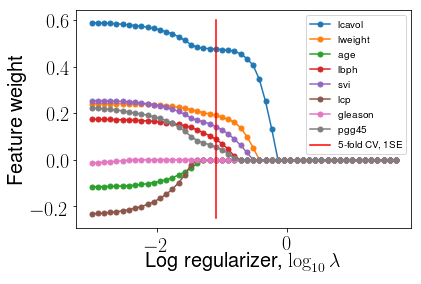

In [22]:
fig, ax = plt.subplots(1,1)
for i, feat_name in enumerate(features):
    ax.plot(np.log10(alpha_space), coef_alpha[:,i],'.-',label=feat_name)

ax.plot(np.log10(alpha_space[optimal_model])*np.ones(50),np.linspace(-0.25,0.6),'-r', label = '5-fold CV, 1SE')
ax.legend(prop={'size':10})
ax.set_xlabel('Log regularizer, $\log_{10} \lambda$')
ax.set_ylabel('Feature weight');

As the regularizer is increased, parameters become smaller and the solution becomes more sparse. The red vertical line is the value of $\lambda$ chosen using 5-fold cross-validation using the 1 SE rule. This is a compromise between sparsity and minimising reconstruction error.